In [ ]:
# default_exp core

# Core functionality

> Memory profiling.

In [ ]:
#hide
from nbdev.showdoc import *

## Memory hooks

Inspired by https://www.sicara.ai/blog/2019-28-10-deep-learning-memory-usage-and-pytorch-optimization-tricks

In [ ]:
#export
import torch
from torch import Tensor
import torch.nn as nn
from fastai.callback.all import Hooks, ShortEpochCallback, HookCallback
from fastai.basics import *

In [ ]:
#export
def _generate_mem_hook(mem_log, idx, hook_type, experiment):
    "Hook function generator"
    def hook(module, *args):
        inp_shape = args[0][0].shape
        out_shape = args[1][0].shape if len(args)>1 else None
        if len(mem_log) == 0: call_idx = 0
        else: call_idx = mem_log[-1]["call_idx"] + 1
        mem_all = torch.cuda.memory_allocated()
        mem_reserved = torch.cuda.memory_reserved()
        torch.cuda.synchronize()
        mem_log.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(module).__name__,
            'experiment': experiment,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_reservd': mem_reserved,
            'input_shape': inp_shape,
            'output_shape': out_shape,
        })
    return hook

In [ ]:
#export
class MemHooks(Hooks):
    "Creates hooks for logging memory stats"
    def __init__(self, modules, name=None):
        self.hooks = []
        self.mem_log = []
        for i, m in enumerate(modules): self.register_memory_hooks(m, i, name=name)

    def register_memory_hooks(self, m, i, name=None):
        fs = {'pre':m.register_forward_pre_hook,
              'fwd':m.register_forward_hook,
              'bwd':m.register_backward_hook}
        for hook_type in ['pre', 'fwd', 'bwd']:
            self.hooks.append(fs[hook_type](_generate_mem_hook(self.mem_log, i, hook_type, name)))

## Memory profiling functionality

In [ ]:
#export
def plot_log(mem_log:pd.DataFrame):
    plt.plot(mem_log['call_idx'], mem_log['mem_all']/1024)
    plt.ylabel('Memory allocated (Kb)');

In [ ]:
#export
def reset_grad(model:nn.Module):
    for p in model.parameters():
        p.grad = None

In [ ]:
#export
def profile_memory(model:nn.Module, xb:Tensor, yb:Tensor, loss_func=CrossEntropyLossFlat(), plot=True, label=None):
    label = ifnone(label, type(model).__name__)
    device = xb.device
    model.to(device)
    prealloc = torch.cuda.memory_allocated()
    with MemHooks(flatten_model(model), label) as h:
        out = model(xb)
        loss = loss_func(out, yb)
        loss.backward()
        reset_grad(model)
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    mem_log['mem_all'] = mem_log['mem_all'] - prealloc
    if plot:
        plot_log(mem_log)
    return mem_log

In [ ]:
#cuda
ni = 100
no = 2
xb, yb = torch.randn(32, ni).cuda(), torch.randint(no, (32,)).cuda()
def simple_model(ni=100, no=2, n=4):
    layers = [nn.Linear(ni, ni) for i in range(n)] + [nn.Linear(ni,no)]
    return nn.Sequential(*layers)

In [ ]:
#hide
class SimpleModel(Module):
    def __init__(self, d=100, n=4):
        self.layers = nn.ModuleList([nn.Linear(d, d) for i in range(n)] + [nn.Linear(d,2)])
    def forward(self, x):
        for m in self.layers:
            x = m(x)
        return x
# model = SimpleModel()

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Linear,Sequential,pre,0,2097152,"(32, 100)",None
1,0,1,Linear,Sequential,fwd,12800,2097152,"(32, 100)","(100,)"
2,1,2,Linear,Sequential,pre,12800,2097152,"(32, 100)",None
3,1,3,Linear,Sequential,fwd,25600,2097152,"(32, 100)","(100,)"
4,2,4,Linear,Sequential,pre,25600,2097152,"(32, 100)",None
5,2,5,Linear,Sequential,fwd,38400,2097152,"(32, 100)","(100,)"
6,3,6,Linear,Sequential,pre,38400,2097152,"(32, 100)",None
7,3,7,Linear,Sequential,fwd,51200,2097152,"(32, 100)","(100,)"
8,4,8,Linear,Sequential,pre,51200,2097152,"(32, 100)",None
9,4,9,Linear,Sequential,fwd,51712,2097152,"(32, 100)","(2,)"


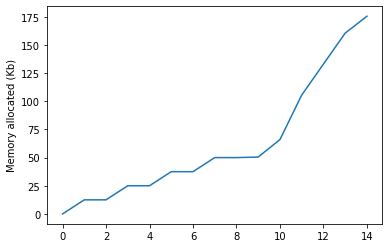

In [ ]:
#cuda
mem_log = profile_memory(simple_model(), xb, yb)
mem_log

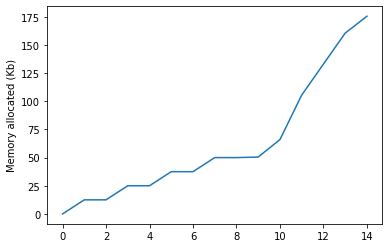

In [ ]:
#hide
#cuda
plot_log(mem_log)

In [ ]:
#export
class MemProfileCallback(Callback):
    "Cancels batch after backward to avoid opt.step()"
    def before_batch(self):
        # self._split(self.dls.one_batch())
        # self.model.to(self.dls.device)
        self.model.train()
        self.learn.training = True
    def after_backward(self):
        print('Batch canceled')
        raise CancelBatchException

In [ ]:
#export
@patch
def profile_memory(self:Learner, plot=True):
    with MemHooks(flatten_model(self.model), type(self.model).__name__) as h:
        self._split(self.dls.one_batch())
        self.model.to(self.dls.device)
        prealloc = torch.cuda.memory_allocated()
        with self.added_cbs(MemProfileCallback()), self.no_logging():
            self('before_batch')
            try: self._do_one_batch()
            except CancelBatchException:
                for p in self.model.parameters(): p.grad=None
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    mem_log['mem_all'] = mem_log['mem_all'] - prealloc
    if plot:
        plt.plot(mem_log['call_idx'], mem_log['mem_all']/1024)
        
    return mem_log

In [ ]:
#cuda
train = [(torch.randn(100), torch.randint(2, (1,))) for _ in range(800)]
valid = [(torch.randn(100), torch.randint(2, (1,))) for _ in range(200)]

dls = DataLoaders.from_dsets(train, valid, bs=16, device='cuda')

In [ ]:
#cuda
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat())

Batch canceled


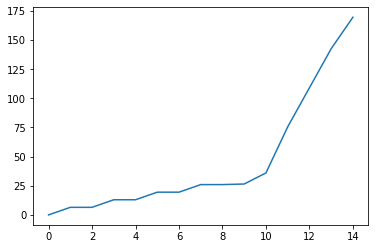

In [ ]:
#cuda
mem_log1 = learn.profile_memory()

In [ ]:
#cuda
mem_log1

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Linear,Sequential,pre,0,2097152,"(16, 100)",None
1,0,1,Linear,Sequential,fwd,6656,2097152,"(16, 100)","(100,)"
2,1,2,Linear,Sequential,pre,6656,2097152,"(16, 100)",None
3,1,3,Linear,Sequential,fwd,13312,2097152,"(16, 100)","(100,)"
4,2,4,Linear,Sequential,pre,13312,2097152,"(16, 100)",None
5,2,5,Linear,Sequential,fwd,19968,2097152,"(16, 100)","(100,)"
6,3,6,Linear,Sequential,pre,19968,2097152,"(16, 100)",None
7,3,7,Linear,Sequential,fwd,26624,2097152,"(16, 100)","(100,)"
8,4,8,Linear,Sequential,pre,26624,2097152,"(16, 100)",None
9,4,9,Linear,Sequential,fwd,27136,2097152,"(16, 100)","(2,)"


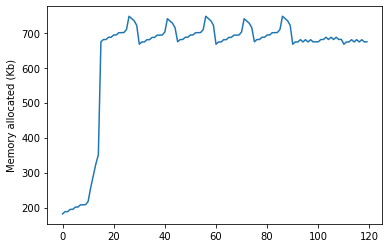

In [ ]:
#slow
with MemHooks(flatten_model(learn.model), 'test') as h:
    learn.fit(1, 1e-3, cbs=ShortEpochCallback(pct=0.1))
mem_log2 = pd.DataFrame(h.mem_log, copy=True)
plot_log(mem_log2)

## Memory callback

In [ ]:
#hide
class HookCallback(Callback):
    "`Callback` that can be used to register hooks on `modules`"
    _methods = ["hook"]
    hook = noops
    def __init__(self, modules=None, every=None, remove_end=True, is_forward=True, detach=True, cpu=True, **kwargs):
        store_attr('modules,every,remove_end,is_forward,detach,cpu')
        assert not kwargs

    def before_fit(self):
        "Register the `Hooks` on `self.modules`."
        if self.modules is None: self.modules = [m for m in flatten_model(self.model) if has_params(m)]
        if self.every is None: self._register()

    def before_batch(self):
        if self.every is None: return
        if self.training and self.train_iter%self.every==0: self._register()

    def after_batch(self):
        if self.every is None: return
        if self.training and self.train_iter%self.every==0: self._remove()

    def after_fit(self):
        "Remove the `Hooks`."
        if self.remove_end: self._remove()

    def _register(self): self.hooks = Hooks(self.modules, self.hook, self.is_forward, self.detach, self.cpu)
    def _remove(self):
        if getattr(self, 'hooks', None): self.hooks.remove()

    def __del__(self): self._remove()

In [ ]:
#export
class MemStatsCallback(HookCallback):
    "Registers memory hooks on modules"
    def __init__(self, modules=None, label=None, remove_end=True):
        store_attr()
        self.prealloc = torch.cuda.memory_allocated()
        self.every = None
    
    def _register(self): self.hooks = MemHooks(self.modules, name=self.label)
        
    def after_fit(self):
        self.stats = pd.DataFrame(self.hooks.mem_log, copy=True)
        self.stats['mem_all'] = self.stats['mem_all'] - self.prealloc
        if self.remove_end: self._remove()
    
    def plot(self): plot_log(self.stats)

In [ ]:
#cuda
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback())
learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])

In [ ]:
#cuda
learn.mem_stats.stats

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Linear,None,pre,172544,2097152,"(16, 100)",None
1,0,1,Linear,None,fwd,179200,2097152,"(16, 100)","(100,)"
2,1,2,Linear,None,pre,179200,2097152,"(16, 100)",None
3,1,3,Linear,None,fwd,185856,2097152,"(16, 100)","(100,)"
4,2,4,Linear,None,pre,185856,2097152,"(16, 100)",None
...,...,...,...,...,...,...,...,...,...
115,2,115,Linear,None,fwd,683008,2097152,"(16, 100)","(100,)"
116,3,116,Linear,None,pre,676352,2097152,"(16, 100)",None
117,3,117,Linear,None,fwd,683008,2097152,"(16, 100)","(100,)"
118,4,118,Linear,None,pre,676352,2097152,"(16, 100)",None


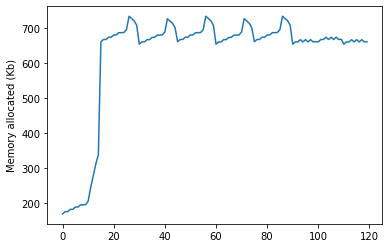

In [ ]:
#cuda
learn.mem_stats.plot()

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
